# Report 1
## Computational Neuroscience
## Computer Assignment 1
### Aref Afzali
### 610098014

In [1]:
%matplotlib notebook
import torch
import numpy as np

In [2]:
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.plotting.plotting import plotting
from cnsproject.utils import step_function, two_way_step_function, random_step_function
from cnsproject.network.monitors import Monitor

## Global Variables

$time$ parameter shows how often (seconds\*scale/dt) we want to run our neuron. $dt$ means with what resolution ($scale$) we want our seconds move forward.

In [3]:
time = 1500
dt = 1
scale = 100
step_size = 1
shape = (1,)
spike_trace = True
additive_spike_trace = True
tau_s = 10.
trace_scale = 1.
is_inhibitory = False
learning = False
R = 10
C = 10

## Description

After defining our parameters, we need to modify a electric current($I$). There are 3 functions that modified in utils file which are `step_function`, `two_way_step_function`, and `random_step_function`. Inputs of them are $time: int$, and $step\_size: int$. step_size is the scale value for the step functions. But it is the maximum value that random steps in the random function will produce.

In [4]:
I = step_function(time, step_size, scale)

In this step we will create LIF neuron model. The definition of inputs are written in its source code.

In [5]:
neuron = LIFPopulation(
            shape, spike_trace, additive_spike_trace, tau_s, trace_scale,
            is_inhibitory, learning, R, C
        )
neuron.dt = dt

For the next step, we should define a Monitor to be able to monitor the neuron in the $time$ duration. The parameters that we are going to monitor are $s$ and $u$. $s$ is a list with the length of time which is filled with whether the neuron spikes in that time or not. $u$ also has the same length as $s$ and shows the potential for each time.

In [6]:
monitor = Monitor(neuron, state_variables=["s", "u"])
monitor.set_time_steps(time, neuron.dt)
monitor.reset_state_variables()

In this part, we give the neuron the current in each resolution and track its action with monitor.


In `forward` function two steps handled:
<ol>
    <li>Compute Potential:</li> For computing the potential at each moment, I used the below formula:
    $U(t+\Delta) = U(t) - (\Delta/\tau).[(U(t) - U_{rest}) - R.I(t)]$
    <li>Check spiking:</li> For checking whether the neuron spikes or not, I used the threshold to see whether the potential crosses it or not.
</ol>


In [7]:
for i in range(len(I)):
    neuron.forward(I[i][0])
    monitor.record()

After iterating the current, we can get the spike and the potential for each resolution in time.

In [8]:
s = monitor.get("s")
s = torch.transpose(s*1, 0, 1)
u = monitor.get("u")

For plotting the current and potential, you can use the plotting class which has a initial function (here is `plot_ut_it_init`) that reset and prepare the plot. After initailization, you can update the plot with its relevent function (here is `plot_ut_it_update`). Till the time you initial another plot, you will be able to show multiple plots (with `show` function).

<IPython.core.display.Javascript object>


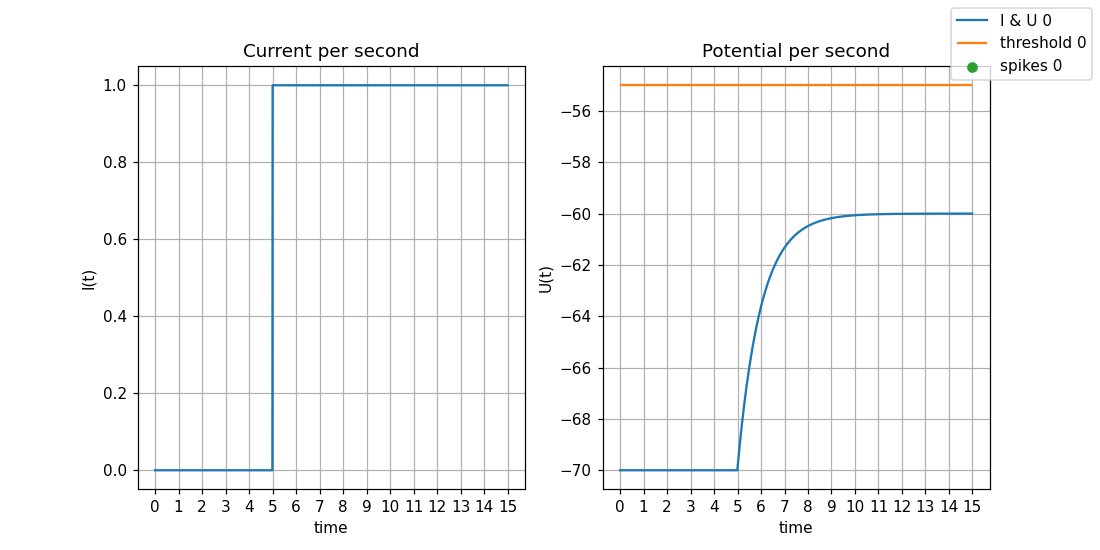

In [9]:
plot = plotting()
plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

## Neuron Behavior

The next function is all the above steps together and return the neuron, current, a list of spikes, and a list of potentials.

In [10]:
def single_neuron_time(
        time, dt, scale, step_size, I_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C, threshold = -55
    ):
    
    I = I_function(time, step_size, scale)
    neuron = LIFPopulation(
            shape, spike_trace, additive_spike_trace, tau_s, trace_scale,
            is_inhibitory, learning, R, C, threshold
        )
    neuron.dt = dt
    monitor = Monitor(neuron, state_variables=["s", "u"])
    monitor.set_time_steps(time, dt)
    monitor.reset_state_variables()
    for i in range(len(I)):
        neuron.forward(I[i][0])
        monitor.record()
    return neuron, I, torch.transpose(monitor.get("s")*1, 0, 1), monitor.get("u")

The default of the parameters of a neuron is as follow:

<IPython.core.display.Javascript object>


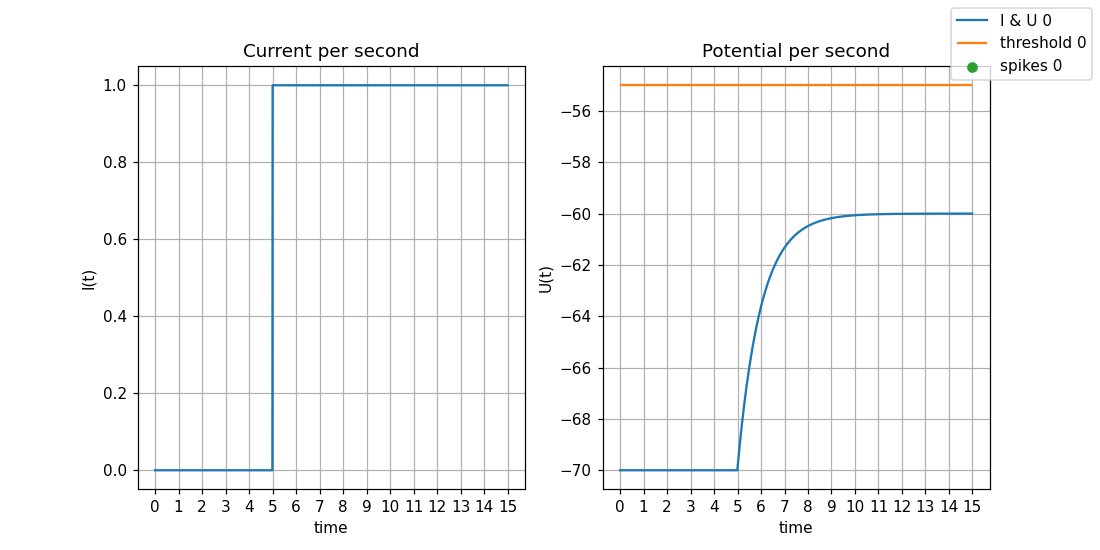

CPU times: user 318 ms, sys: 8.49 ms, total: 327 ms
Wall time: 323 ms


In [11]:
%%time
plot = plotting()

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next cell is showing how the size of the step function (electric current) affects on a neuron. By increasing the step function value, the growth rate of potential increases.

<IPython.core.display.Javascript object>


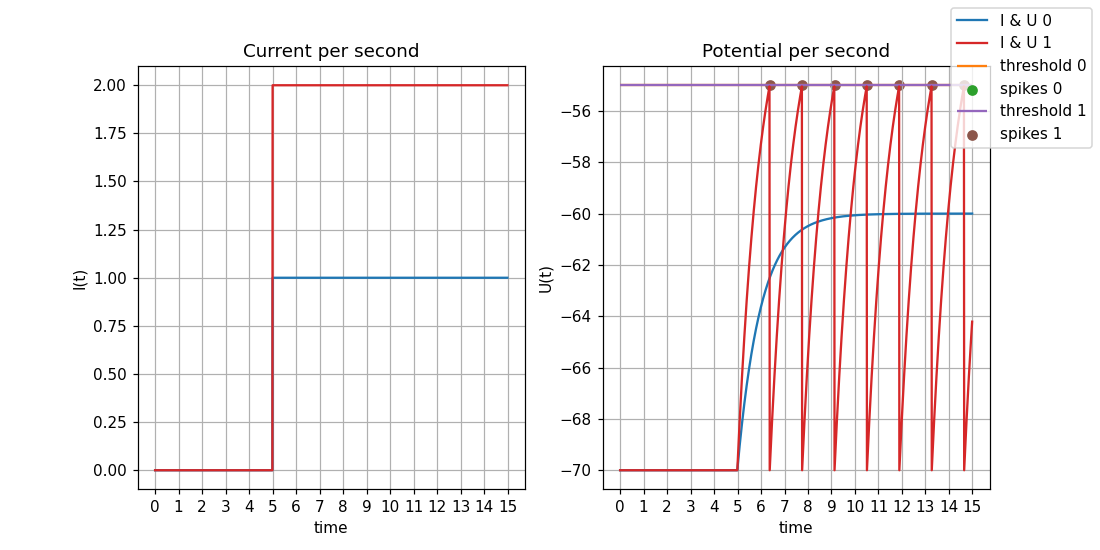

CPU times: user 615 ms, sys: 6.55 ms, total: 622 ms
Wall time: 622 ms


In [25]:
%%time

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])

neuron, I, s, u = single_neuron_time(
        time, dt, scale, 2, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next cell is showing how the threshold affects on a neuron. By decreasing the threshold value, the growth rate of potential won't change and the only difference should be the number of spikes.

<IPython.core.display.Javascript object>


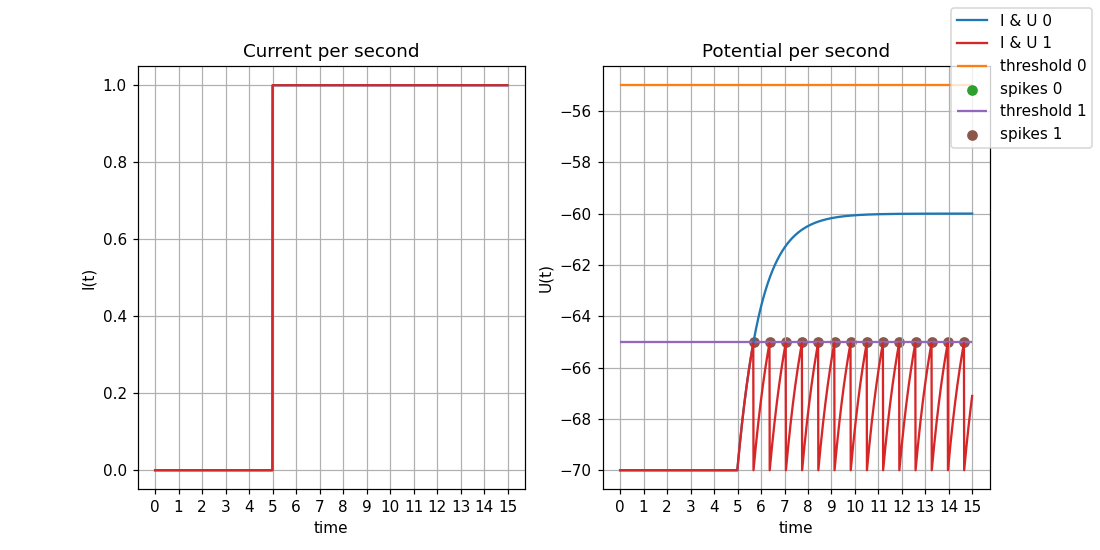

CPU times: user 573 ms, sys: 18.9 ms, total: 592 ms
Wall time: 593 ms


In [21]:
%%time

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C, threshold = -65
    )
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next cell is showing how the Resistance ($R$) affects on a neuron. By decreasing $R$, the growth rate of potential decreases which it means it will take less time to reach the stable potential and also the stable point decreases.

<IPython.core.display.Javascript object>


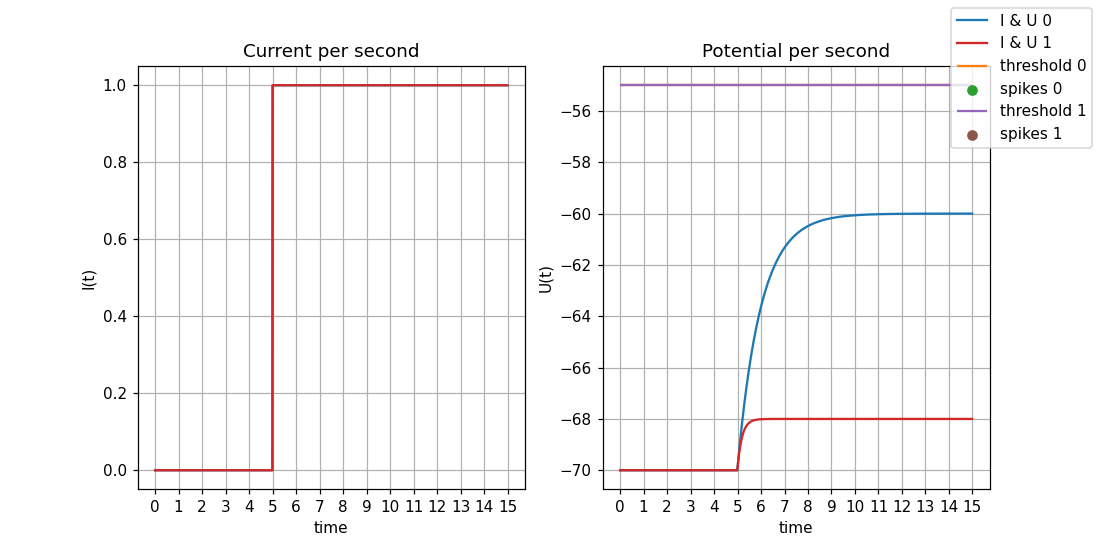

CPU times: user 586 ms, sys: 3.49 ms, total: 590 ms
Wall time: 591 ms


In [23]:
%%time

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, 2, C
    )
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next cell is showing how the Capasitor ($C$) affects on a neuron. By decreasing $C$, the growth rate of potential increases which it means it will take less time to reach the stable potential but unlike $R$, the stable point in this situation doesn't change.

<IPython.core.display.Javascript object>


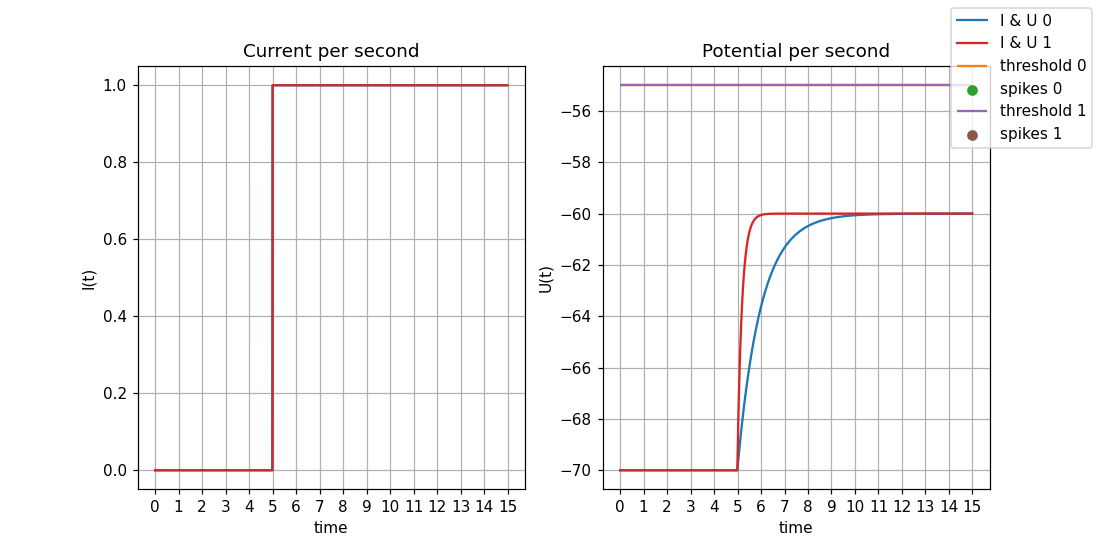

CPU times: user 616 ms, sys: 5.99 ms, total: 622 ms
Wall time: 624 ms


In [14]:
%%time
neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, 2
    )
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next cell is showing how the $\Delta$ affects on a neuron. $\Delta$ can shift the U/t figure.

<IPython.core.display.Javascript object>


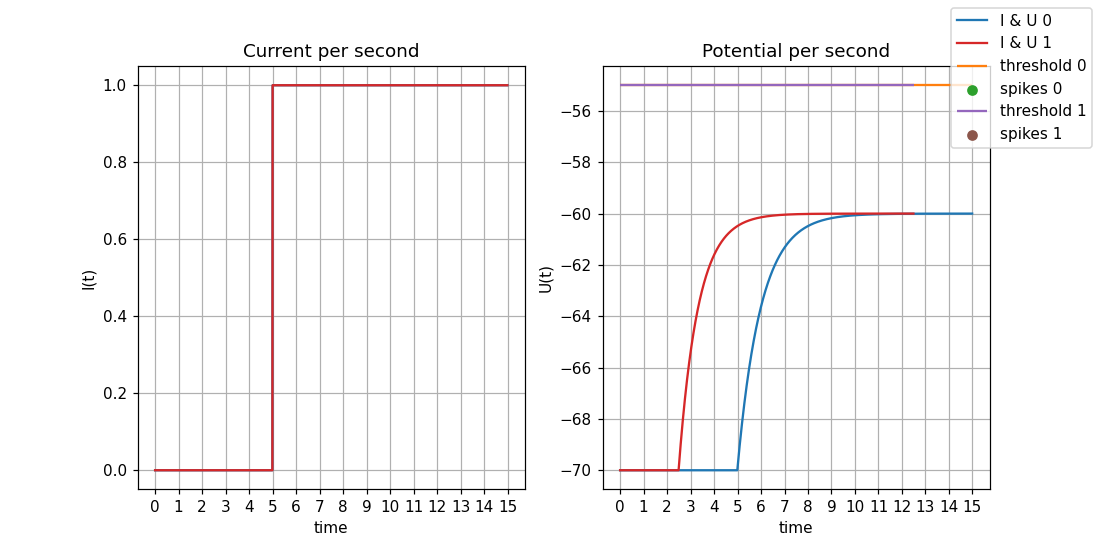

CPU times: user 618 ms, sys: 4.66 ms, total: 623 ms
Wall time: 620 ms


In [15]:
%%time
neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])

neuron, I, s, u = single_neuron_time(
        time, 1.2, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next cell has a different step function ($I$). which we can see that after the second change, the neuron's potentional is gradually decreasing to its rest potetional.

<IPython.core.display.Javascript object>


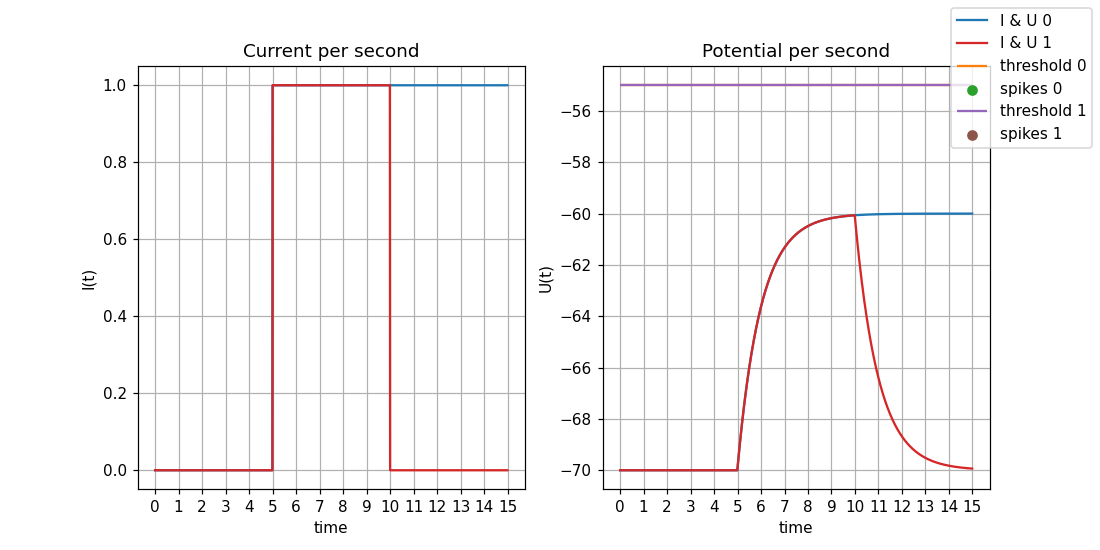

CPU times: user 583 ms, sys: 8.16 ms, total: 591 ms
Wall time: 588 ms


In [16]:
%%time
neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])

neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, two_way_step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

The next neuron has a random current($I$) as input.

<IPython.core.display.Javascript object>


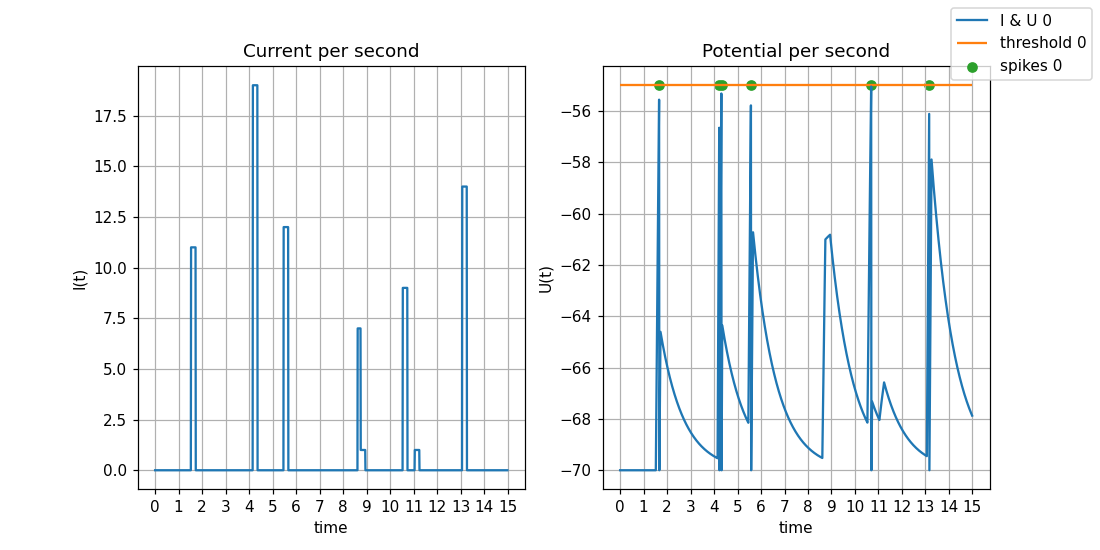

CPU times: user 389 ms, sys: 11.4 ms, total: 401 ms
Wall time: 395 ms


In [17]:
%%time
step_size = 20
neuron, I, s, u = single_neuron_time(
        time, dt, scale, step_size, random_step_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold, s[0].nonzero(as_tuple=True)[0])
plot.show()

In the next cell, we are checking out the behavior of a neuron with different normal step function values. In the end, we plot the figure which shows the spikes frequency in each step function's value.

<IPython.core.display.Javascript object>


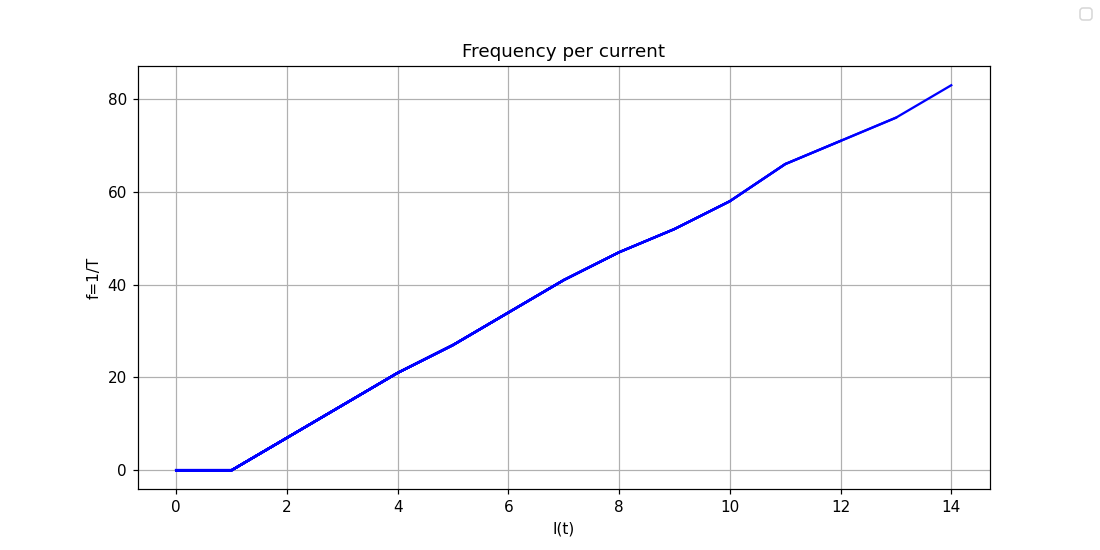

No handles with labels found to put in legend.


CPU times: user 4.48 s, sys: 80.3 ms, total: 4.56 s
Wall time: 4.73 s


In [18]:
%%time
plot.plot_fi_init()
spikes = []
for x in range(15):
    _, _, s, _ = single_neuron_time(
            time, dt, scale, x, step_function, shape, spike_trace,
            additive_spike_trace, tau_s, trace_scale,
            is_inhibitory, learning, R, C
        )
    spikes.append(s[0].sum())
    plot.plot_fi_update(spikes)

plot.show()